In [25]:
#IMPORTING ALL LIBRARIES 
import pandas as pd
import numpy as np
import json
import random
from pandas import json_normalize
import networkx as nx
import matplotlib as mpl
import matplotlib.pyplot as plt
import gravis as gv
# import pyproj
import utm
import math
# import io
# import gc
# from scipy.spatial import ConvexHull, Voronoi, voronoi_plot_2d
# from scipy import stats

# from functools import partial
from IPython.display import display, clear_output
# import concurrent.futures
from tqdm.contrib.concurrent import thread_map

import tweepy
import os
from dotenv import load_dotenv


# Required Libraries
from tqdm import tqdm as tqdmBasic
# import time

from sklearn.cluster import KMeans
import seaborn as sns; sns.set_theme()

In [3]:
# Variáveis para uso da API

# Load the .env file
load_dotenv()

# Get the keys from the .env file
consumer_key = os.environ.get('TWITTER_API_KEY')
consumer_secret = os.environ.get('TWITTER_API_KEY_SECRET')
access_token = os.environ.get('TWITTER_ACCESS_TOKEN')
access_token_secret = os.environ.get('TWITTER_ACCESS_TOKEN_SECRET')
bearer_token = os.environ.get('TWITTER_BEARER_TOKEN')

# Authenticate with the twitter API
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)

# Create the API object
api = tweepy.API(auth, wait_on_rate_limit=True)

In [4]:
# Dicionario a ser preenchido com chaves sendo o author_id e os valores sendo o username
if os.path.exists(r'E://Dict_Author_Id_to_Username.json'):
    with open(r'E://Dict_Author_Id_to_Username.json', 'r') as fp:
        author_id_to_username = json.load(fp)
        print(f"Foram carregadas {len(author_id_to_username)} chaves do arquivo JSON")
else:
    author_id_to_username = {}

Foram carregadas 181528 chaves do arquivo JSON


In [5]:
def community_layout(g, partition):
    """
    Compute the layout for a modular graph.


    Arguments:
    ----------
    g -- networkx.Graph or networkx.DiGraph instance
        graph to plot

    partition -- dict mapping int node -> int community
        graph partitions


    Returns:
    --------
    pos -- dict mapping int node -> (float x, float y)
        node positions

    """

    pos_communities = _position_communities(g, partition, scale=3.)

    pos_nodes = _position_nodes(g, partition, scale=1.)

    # combine positions
    pos = dict()
    for node in g.nodes():
        pos[node] = pos_communities[node] + pos_nodes[node]

    return pos

def _position_communities(g, partition, **kwargs):

    # create a weighted graph, in which each node corresponds to a community,
    # and each edge weight to the number of edges between communities
    between_community_edges = _find_between_community_edges(g, partition)

    communities = set(partition.values())
    hypergraph = nx.DiGraph()
    hypergraph.add_nodes_from(communities)
    for (ci, cj), edges in between_community_edges.items():
        hypergraph.add_edge(ci, cj, weight=len(edges))

    # find layout for communities
    pos_communities = nx.spring_layout(hypergraph, **kwargs)

    # set node positions to position of community
    pos = dict()
    for node, community in partition.items():
        pos[node] = pos_communities[community]

    return pos

def _find_between_community_edges(g, partition):

    edges = dict()

    for (ni, nj) in g.edges():
        ci = partition[ni]
        cj = partition[nj]

        if ci != cj:
            try:
                edges[(ci, cj)] += [(ni, nj)]
            except KeyError:
                edges[(ci, cj)] = [(ni, nj)]

    return edges

def _position_nodes(g, partition, **kwargs):
    """
    Positions nodes within communities.
    """

    communities = dict()
    for node, community in partition.items():
        try:
            communities[community] += [node]
        except KeyError:
            communities[community] = [node]

    pos = dict()
    for ci, nodes in communities.items():
        subgraph = g.subgraph(nodes)
        pos_subgraph = nx.spring_layout(subgraph, **kwargs)
        pos.update(pos_subgraph)

    return pos

In [6]:
def load_jsonl(input_path) -> list:
    """
    Read list of objects from a JSON lines file.
    """
    data = []
    with open(input_path, 'r', encoding='utf-8') as f:
        for line in f:
            data.append(json.loads(line.rstrip('\n|\r')))
    print('Loaded {} records from {}'.format(len(data), input_path))
    return data

In [7]:
def geraDictMentionsByUser(data_frame: pd.DataFrame, mentionsUnicas = True) -> dict:
    dataEditado = data_frame['entities_mentions']
    dataEditado.dropna(inplace=True)
    # dataEditado.reset_index(drop=True, inplace=True)
    dataEditado = dataEditado.to_frame()
    
    mentionsUsuario = {}

    # Percorrendo teste1 e adicionando os usernames no dicionário usando o id do usuário como chave
        
    for mention in dataEditado.itertuples():
        usuariosMencionados = []
        
        coluna = 'author_id' #'username' if data_frame['username'].at[mention.Index] != '' else 'author_id'
        
        if data_frame[coluna].at[mention.Index] not in mentionsUsuario:
            mentionsUsuario[data_frame[coluna].at[mention.Index]] = []
            
        for usuario in mention[1]:
            usuariosMencionados.append(usuario['username'])
            mentionsUsuario[data_frame[coluna].at[mention.Index]].extend(usuariosMencionados)
        
    if mentionsUnicas:
        mentionsUsuario = {k: list(dict.fromkeys(v)) for k, v in mentionsUsuario.items()}
        
    return mentionsUsuario

In [8]:
def geraDictLinkTweets(data_frame) -> list:
    dataEditado = data_frame['entities_urls']
    dataEditado.dropna(inplace=True)
    # dataEditado.reset_index(drop=True, inplace=True)
    dataEditado = dataEditado.to_frame()
    
    linksTweets = {}

    # Percorrendo teste1 e adicionando os usernames no dicionário usando o id do usuário como chave
        
    contador = 1
    for link in dataEditado.itertuples():
        print(f"Link {contador} de {dataEditado.shape[0]}")
        
        linksTweet = []
        if data_frame['author_id'].at[link.Index] not in linksTweets:
            linksTweets[data_frame['author_id'].at[link.Index]] = []
            
        for linkTweet in link[1]:
            linksTweet.append(linkTweet['expanded_url'])
            linksTweets[data_frame['author_id'].at[link.Index]].extend(linksTweet)
        contador += 1
        
    return linksTweets

In [9]:
def returnMediaDictListas(dict : dict) -> float:
    soma = 0
    for key in dict:
        soma += len(dict[key])
    return soma/len(dict)

In [10]:
def get_username(author_id: str):
    """Recupera o username do usuário a partir do author_id e atualiza o dicionário author_id_to_username

    Args:
        author_id: O id do usuário 
    """
    if author_id in author_id_to_username.keys():
        return
    
    author_id_to_username[author_id] = ''
    try:
        user = api.get_user(user_id=author_id)  
        author_id_to_username[author_id] = user.screen_name
    except:
        pass
        


In [11]:
def returnDataFrameWithUsernames(dataFrame : pd.DataFrame) -> pd.DataFrame:      
    dataFrame['username'] = ''
    
    thread_map(get_username, [id for id in dataFrame['author_id']], max_workers=16, total=dataFrame.shape[0])
        
    for index, row in dataFrame.iterrows():
        dataFrame['username'].at[index] = author_id_to_username[row['author_id']]
    
    return dataFrame

In [12]:
def degree_histogram_directed(G, in_degree=False, out_degree=False):
    """Return a list of the frequency of each degree value.

    Parameters
    ----------
    G : Networkx graph
       A graph
    in_degree : bool
    out_degree : bool

    Returns
    -------
    hist : list
       A list of frequencies of degrees.
       The degree values are the index in the list.

    Notes
    -----
    Note: the bins are width one, hence len(list) can be large
    (Order(number_of_edges))
    """
    nodes = G.nodes()
    if in_degree:
        in_degree = dict(G.in_degree())
        degseq=[in_degree.get(k,0) for k in nodes]
    elif out_degree:
        out_degree = dict(G.out_degree())
        degseq=[out_degree.get(k,0) for k in nodes]
    else:
        degseq=[v for k, v in G.degree()]
    dmax=max(degseq)+1
    freq= [ 0 for d in range(dmax) ]
    for d in degseq:
        freq[d] += 1
    return freq

In [13]:
def _export_dictionary(dict : dict, path : str = 'E://', file_name : str = 'dict.json'):
    """Exporta um dicionário para um arquivo JSON

    Args:
        dict (dict): dicionário a ser exportado
        path (str, optional): Caminho do arquivo de saída. Defaults to ''.
        file_name (str, optional): Nome do arquivo de saída. Defaults to 'dict.json'.
    """                
    with open(f"{path}{file_name}", 'w') as f:
        json.dump(dict, f)

In [14]:
def processRawData(data : dict | list[dict]) -> pd.DataFrame:
    data_frame = json_normalize(data,record_path = ['data'], sep = '_', errors ='ignore')
        
    data_frame['lat'] = data_frame['geo_coordinates_coordinates'].str.get(1)
    data_frame['lon'] = data_frame['geo_coordinates_coordinates'].str.get(0)

    #cleaning fields that will not be used
    try:
        # del data_frame['entities_mentions']
        del data_frame['context_annotations']
        # del data_frame['entities_urls']
        # del data_frame['entities_cashtags']
        del data_frame['withheld_copyright']
        del data_frame['withheld_country_codes']
        del data_frame['withheld_scope']
    except:
        pass
    
    return data_frame

In [ ]:
#removing exact same twitter locations; removing non-geo-tagged tweets; filtering portuguese assigned posts and repeated tweets
data.drop(data.loc[data['geo_coordinates_coordinates'].isnull()].index, inplace=True)
# data.drop(data.loc[data['lang'] != 'pt'].index, inplace=True)
data = data.drop_duplicates(subset=['lat', 'lon'], keep=False)
# data = data.drop_duplicates(subset=['text'], keep=False)

In [ ]:
dataFrameComUsernames = pd.DataFrame()

for file in os.listdir(r"D:\Documentos\data_and_code\all_data_lisbon\data_in_parts"):
    if file.endswith('.jsonl'):
        data2 = load_jsonl(os.path.join(r"D:\Documentos\data_and_code\all_data_lisbon\data_in_parts", file))
        
        data_frame = processRawData(data2)
        
        dataFrameParcial = returnDataFrameWithUsernames(data_frame)
        newFile = "data_processed_" + file + ".jsonl"
        dataFrameParcial.to_json(os.path.join(r'D:\\Documentos\\data_and_code\\all_data_lisbon\\', newFile), orient='records', lines=True)
        
        _export_dictionary()
        
        dataFrameComUsernames = dataFrameComUsernames._append(dataFrameParcial, ignore_index=True)
        

In [ ]:
data.to_json(r'D:\\Documentos\\data_and_code\\all_data_lisbon\\data_processed2.jsonl', orient='records', lines=True)
# data.to_json(r'E:\\data_processed2.jsonl', orient='records', lines=True)


In [14]:
del fp

In [ ]:
# data2 = load_jsonl(f"E:\\data_processed_137.jsonl")
# data2 = load_jsonl(f"E:\\data_processed_30k.jsonl")
data2 = load_jsonl(r'E:\\data_processed_geotag.jsonl')
# data2 = load_jsonl(r'D:\Documentos\data_and_code\all_data_lisbon\data_complete.jsonl')
data_frame = json_normalize(data2, sep = '_', errors ='ignore')

In [ ]:
# data_frame = json_normalize(data2,record_path = ['data'], sep = '_', errors ='ignore')
data_frame = json_normalize(data2, sep = '_', errors ='ignore')

In [ ]:
data_frame['lat'] = data_frame['geo_coordinates_coordinates'].str.get(1)
data_frame['lon'] = data_frame['geo_coordinates_coordinates'].str.get(0)

#cleaning fields that will not be used
try:
    # del data_frame['entities_mentions']
    del data_frame['context_annotations']
    # del data_frame['entities_urls']
    # del data_frame['entities_cashtags']
    del data_frame['withheld_copyright']
    del data_frame['withheld_country_codes']
    del data_frame['withheld_scope']
except:
    pass

In [ ]:
# Converter uma lista para dataframe
dataFrameComUsernames = returnDataFrameWithUsernames(data_frame)


In [ ]:
# Select the row from data_frame3 where the author_id is equal to 230503899
dataFrameComUsernames.loc[dataFrameComUsernames['author_id'] == '230503899']

In [ ]:
noUserWithMentions = dataFrameComUsernames.loc[dataFrameComUsernames['username'] == '']
noUserWithMentions= noUserWithMentions.loc[noUserWithMentions['entities_mentions'].notnull()]

In [ ]:
dictMentions = geraDictMentionsByUser(dataFrameComUsernames)

In [ ]:
dataFrameComUsernames.to_json(r'D:\\Documentos\\data_and_code\\all_data_lisbon\\completeDataWithUserNames.jsonl', orient='records', lines=True)
# dfMencoes.to_json(r'D:\\Documentos\\data_and_code\\all_data_lisbon\\mentions.jsonl', orient='records', lines=True)

In [ ]:
def process_file(file: str) -> pd.DataFrame:
    """Processa um arquivo JSONL e retorna um dataframe

    Args:
        file (str): Caminho do arquivo JSONL

    Returns:
        pd.DataFrame: Dataframe com os dados do arquivo JSONL
    """
    print(f"Processando arquivo {file}")
    df = json_normalize(load_jsonl(file), sep='_', errors='ignore')
    return df

In [ ]:
dataFrameComUsernames = pd.DataFrame()

results = thread_map(process_file, [f"D:\\Documentos\\data_and_code\\all_data_lisbon\\data_processed_data_{i+1}.jsonl" for i in range(6)], max_workers=16, total=6)

# results = thread_map(process_file, [r"E:\data_processed_geotag.jsonl"], max_workers=16, total=1)

for df in results:
    dataFrameComUsernames = dataFrameComUsernames._append(df, ignore_index=True)
        
del results

Processando arquivo D:\Documentos\data_and_code\all_data_lisbon\data_processed_data_1.jsonl
Processando arquivo D:\Documentos\data_and_code\all_data_lisbon\data_processed_data_2.jsonl
Processando arquivo D:\Documentos\data_and_code\all_data_lisbon\data_processed_data_3.jsonl
Processando arquivo D:\Documentos\data_and_code\all_data_lisbon\data_processed_data_4.jsonl
Processando arquivo D:\Documentos\data_and_code\all_data_lisbon\data_processed_data_5.jsonl
Processando arquivo D:\Documentos\data_and_code\all_data_lisbon\data_processed_data_6.jsonl


  0%|          | 0/6 [00:00<?, ?it/s]

Loaded 1004424 records from D:\Documentos\data_and_code\all_data_lisbon\data_processed_data_1.jsonl
Loaded 1404568 records from D:\Documentos\data_and_code\all_data_lisbon\data_processed_data_2.jsonl
Loaded 1904831 records from D:\Documentos\data_and_code\all_data_lisbon\data_processed_data_4.jsonl
Loaded 1665357 records from D:\Documentos\data_and_code\all_data_lisbon\data_processed_data_6.jsonl
Loaded 2004586 records from D:\Documentos\data_and_code\all_data_lisbon\data_processed_data_5.jsonl
Loaded 2105082 records from D:\Documentos\data_and_code\all_data_lisbon\data_processed_data_3.jsonl


In [ ]:
dataFrameComUsernames.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10088848 entries, 0 to 10088847
Data columns (total 19 columns):
 #   Column                       Dtype  
---  ------                       -----  
 0   author_id                    object 
 1   text                         object 
 2   id                           object 
 3   lang                         object 
 4   created_at                   object 
 5   source                       object 
 6   entities_mentions            object 
 7   geo_place_id                 object 
 8   entities_urls                object 
 9   entities_annotations         object 
 10  entities_hashtags            object 
 11  geo_coordinates_type         object 
 12  geo_coordinates_coordinates  object 
 13  entities_cashtags            object 
 14  lat                          float64
 15  lon                          float64
 16  username                     object 
 17  withheld_copyright           object 
 18  withheld_country_codes       object 
dty

In [ ]:
dataFrameComUsernames.dropna(subset=['lat'], inplace=True)
dataFrameComUsernames = dataFrameComUsernames[dataFrameComUsernames['lat'] != 0]


In [ ]:
dataframeEdit = dataFrameComUsernames.copy()
del dataFrameComUsernames
dataframeEdit.drop(columns=['entities_cashtags', 'source', 'entities_annotations', 'withheld_copyright',
                            'withheld_country_codes', 'entities_hashtags', 'geo_coordinates_type', 'geo_coordinates_coordinates'], 
                   inplace=True)

In [ ]:
dataframeEdit.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6547967 entries, 16 to 10088847
Data columns (total 11 columns):
 #   Column             Dtype  
---  ------             -----  
 0   author_id          object 
 1   text               object 
 2   id                 object 
 3   lang               object 
 4   created_at         object 
 5   entities_mentions  object 
 6   geo_place_id       object 
 7   entities_urls      object 
 8   lat                float64
 9   lon                float64
 10  username           object 
dtypes: float64(2), object(9)
memory usage: 599.5+ MB


In [ ]:
dataframeEdit = dataframeEdit.fillna(0)
dataframeEdit.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6547967 entries, 16 to 10088847
Data columns (total 11 columns):
 #   Column             Dtype  
---  ------             -----  
 0   author_id          object 
 1   text               object 
 2   id                 object 
 3   lang               object 
 4   created_at         object 
 5   entities_mentions  object 
 6   geo_place_id       object 
 7   entities_urls      object 
 8   lat                float64
 9   lon                float64
 10  username           object 
dtypes: float64(2), object(9)
memory usage: 599.5+ MB


In [ ]:
dictCoordByUser = {}

for index, row in tqdmBasic(dataframeEdit.iterrows(), total=dataframeEdit.shape[0]):
    if row['username'] not in dictCoordByUser:
        dictCoordByUser[row['username']] = {
            'lat': [],
            'lon': []
        }        
    dictCoordByUser[row['username']]['lat'].append(row['lat'])
    dictCoordByUser[row['username']]['lon'].append(row['lon'])

100%|██████████| 6547967/6547967 [04:51<00:00, 22471.03it/s]


In [ ]:
print(f"Quantidade de usuários: {len(dictCoordByUser)}")

Quantidade de usuários: 116088


In [ ]:
df_mean = pd.DataFrame(columns=["username", "mean_lat", "mean_lon", "median_lat", "median_lon"])

for key in tqdmBasic(dictCoordByUser.keys()):
    df_mean = df_mean._append({
        "username": key,
        "mean_lat": np.mean(dictCoordByUser[key]['lat']),
        "mean_lon": np.mean(dictCoordByUser[key]['lon']),
        "median_lat": np.median(dictCoordByUser[key]['lat']),
        "median_lon": np.median(dictCoordByUser[key]['lon'])
    }, ignore_index=True)

  0%|          | 0/116088 [00:00<?, ?it/s]C:\Users\Cliente\AppData\Local\Temp\ipykernel_15984\1206878645.py:4: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_mean = df_mean._append({
100%|██████████| 116088/116088 [09:53<00:00, 195.55it/s]


In [ ]:
df_mean.head()

,username,mean_lat,mean_lon,median_lat,median_lon
0,Manuela_Lagoa,38.700000,-9.183333,38.700000,-9.183333
1,oblogdoedinho,38.725563,-9.150002,38.725563,-9.150002
2,noventaradio,38.862267,-9.065097,38.864860,-9.060729
3,object82,38.751381,-9.188555,38.716700,-9.156900
4,Itsmarsousa,38.650379,-9.074263,38.661370,-9.077440


,username,mean_lat,mean_lon,median_lat,median_lon,mean_X,mean_Y,median_X,median_Y
0,Manuela_Lagoa,38.700000,-9.183333,38.700000,-9.183333,484058.020170,4.283502e+06,484058.020170,4.283502e+06
1,oblogdoedinho,38.725563,-9.150002,38.725563,-9.150002,486961.074436,4.286333e+06,486961.074864,4.286333e+06
2,noventaradio,38.862267,-9.065097,38.864860,-9.060729,494352.231645,4.301494e+06,494731.412762,4.301782e+06
3,object82,38.751381,-9.188555,38.716700,-9.156900,483615.659822,4.289205e+06,486359.738400,4.285351e+06
4,Itsmarsousa,38.650379,-9.074263,38.661370,-9.077440,493537.927984,4.277983e+06,493262.488755,4.279202e+06


In [ ]:
def convert_to_utm(df: pd.DataFrame, columnLat: str = "latitude", columnLon: str = "longitude", outColumnX: str = "x", outColumnY: str = "y") -> pd.DataFrame:
  """Converte as coordenadas de latitude e longitude para UTM zona 29.

  Args:
      df (pd.DataFrame): Dataframe com as coordenadas de latitude e longitude.
      columnLat (str, optional): Coluna que contém a latitude. Defaults to "latitude".
      columnLon (str, optional): Coluna que contém a longitude. Defaults to "longitude".
      outColumnX (str, optional): Coluna saída em UTM para o eixo X. Defaults to "x".
      outColumnY (str, optional): Coluna saída em UTM para o eixo Y. Defaults to "y".

  Returns:
      pd.DataFrame: Dataframe atualizado com as coordendas em UTM.
  """
  # Obtém as coordenadas de latitude e longitude.

  lat = df[columnLat].values
  lon = df[columnLon].values

  # Converte para UTM.

  easting, northing, zone_number, zone_letter = utm.from_latlon(lat, lon)

  # Adiciona as colunas `mean_X` e `mean_Y` ao dataframe.

  df[outColumnX] = easting
  df[outColumnY] = northing

  return df


In [ ]:
df_mean = convert_to_utm(df_mean, 'mean_lat', 'mean_lon', 'mean_X', 'mean_Y')
df_mean = convert_to_utm(df_mean, 'median_lat', 'median_lon', 'median_X', 'median_Y')

In [ ]:
df_mean.head(20)

,username,mean_lat,mean_lon,median_lat,median_lon,mean_X,mean_Y,median_X,median_Y
0,Manuela_Lagoa,38.700000,-9.183333,38.700000,-9.183333,484058.020170,4.283502e+06,484058.020170,4.283502e+06
1,oblogdoedinho,38.725563,-9.150002,38.725563,-9.150002,486961.074436,4.286333e+06,486961.074864,4.286333e+06
2,noventaradio,38.862267,-9.065097,38.864860,-9.060729,494352.231645,4.301494e+06,494731.412762,4.301782e+06
3,object82,38.751381,-9.188555,38.716700,-9.156900,483615.659822,4.289205e+06,486359.738400,4.285351e+06
4,Itsmarsousa,38.650379,-9.074263,38.661370,-9.077440,493537.927984,4.277983e+06,493262.488755,4.279202e+06
5,dezanovept,38.712820,-9.157721,38.712800,-9.146373,486287.633558,4.284920e+06,487274.203731,4.284917e+06
6,caco_palmela,38.574868,-8.947320,38.574533,-8.946894,504588.798470,4.269602e+06,504625.918845,4.269565e+06
7,AlexDaSilva,38.736127,-9.183350,38.738438,-9.170670,484064.600752,4.287511e+06,485167.123967,4.287765e+06
8,gomesduds,38.731200,-9.230350,38.726100,-9.159134,479978.358679,4.286973e+06,486167.340651,4.286394e+06
9,maumaub,38.712071,-9.331017,38.701993,-9.345489,471220.789628,4.284878e+06,469958.349389,4.283764e+06


In [ ]:
df_mean.to_csv(r"E:/DataFrameUsernameMeansMedians.csv", sep=";", header=False, index=False)

In [30]:
df_mean = pd.read_csv(r"E:/DataFrameUsernameMeansMedians.csv", sep=";", header=None)

C:\Users\Cliente\AppData\Local\Temp\ipykernel_19032\1561608321.py:1: DtypeWarning: Columns (1,2,3,4,5,6,7,8) have mixed types. Specify dtype option on import or set low_memory=False.
  df_mean = pd.read_csv(r"E:/DataFrameUsernameMeansMedians.csv", sep=";", header=None)


In [31]:
df_mean.columns = ["username", "mean_lat", "mean_lon", "median_lat", "median_lon", "mean_X", "mean_Y", "median_X", "median_Y"]
df_mean.head()

,username,mean_lat,mean_lon,median_lat,median_lon,mean_X,mean_Y,median_X,median_Y
0,username,mean_lat,mean_lon,median_lat,median_lon,mean_X,mean_Y,median_X,median_Y
1,Manuela_Lagoa,38.7,-9.18333333,38.7,-9.18333333,484058.0201695964,4283502.065548434,484058.0201695964,4283502.065548434
2,oblogdoedinho,38.72556305044776,-9.150001534925371,38.72556305,-9.15000153,486961.0744357934,4286333.415443861,486961.0748638524,4286333.415393474
3,noventaradio,38.86226743322353,-9.065096915696257,38.86485962,-9.06072863,494352.23164528405,4301494.446264396,494731.4127623029,4301781.836199852
4,object82,38.75138141069397,-9.188555476450512,38.7167,-9.1569,483615.65982184716,4289204.575585471,486359.7383995273,4285350.924191058


In [41]:
df_mean.shape[0]


116089

In [ ]:
for index, row in tqdmBasic(df_mean.iterrows(), total=df_mean.shape[0]):
    eastingMean, northingMean, zone_numberMean, zone_letterMean = utm.from_latlon(row['mean_lat'], row['mean_lon'])
    eastingMedian, northingMedian, zone_numberMedian, zone_letterMedian = utm.from_latlon(row['median_lat'], row['median_lon'])
    
    df_mean['mean_X'].at[index] = eastingMean
    df_mean['mean_Y'].at[index] = northingMean
    df_mean['median_X'].at[index] = eastingMedian
    df_mean['median_Y'].at[index] = northingMedian

100%|██████████| 116088/116088 [00:42<00:00, 2733.25it/s]


In [17]:
df_mean.head()

,username,mean_lat,mean_lon,median_lat,median_lon,mean_X,mean_Y,median_X,median_Y
0,Manuela_Lagoa,38.700000,-9.183333,38.700000,-9.183333,484058.020170,4.283502e+06,484058.020170,4.283502e+06
1,oblogdoedinho,38.725563,-9.150002,38.725563,-9.150002,486961.074436,4.286333e+06,486961.074864,4.286333e+06
2,noventaradio,38.862267,-9.065097,38.864860,-9.060729,494352.231645,4.301494e+06,494731.412762,4.301782e+06
3,object82,38.751381,-9.188555,38.716700,-9.156900,483615.659822,4.289205e+06,486359.738400,4.285351e+06
4,Itsmarsousa,38.650379,-9.074263,38.661370,-9.077440,493537.927984,4.277983e+06,493262.488755,4.279202e+06


In [ ]:
dfMencoes = pd.DataFrame(columns=['author_id', 'mention'])

for index, row in dataFrameComUsernames.iterrows():    
    try:
        for i in range(len(dictMentions[row['author_id']])):
            dfMencoes.loc[len(dfMencoes)] = [row['author_id'], dictMentions[row['author_id']][i]]
    except Exception as e:
        # print(e)
        pass
    
dfMencoes.head()

In [ ]:
dataFrameComUsernames = json_normalize(load_jsonl(r'D:\\Documentos\\data_and_code\\all_data_lisbon\\data_processed_data_1.jsonl.jsonl'), sep = '_', errors ='ignore') 
# dfMencoes = json_normalize(load_jsonl(r'D:\\Documentos\\data_and_code\\all_data_lisbon\\mentions.jsonl'), sep = '_', errors ='ignore')


In [ ]:
dfAuthorAndLocation = json_normalize(load_jsonl(r'D:\\Documentos\\data_and_code\\all_data_lisbon\\data_processed_data_1.jsonl.jsonl'), sep = '_', errors ='ignore') 

In [ ]:
# Imprimindo quantas linhas do dataframe possuem o campo geo_coordinates_coordinates preenchido e quantos não possuem
print(f"Tweets com geotag: {dataFrameComUsernames['geo_coordinates_coordinates'].count()}")
print(f"Tweets sem geotag: {dataFrameComUsernames['geo_coordinates_coordinates'].isnull().sum()}")

In [ ]:
dataFrameComUsernames.shape[0]

In [ ]:
dfCoords = dataFrameComUsernames.loc[:, ['author_id', 'lat', 'lon']]

In [ ]:
# imprimindo os author_id com a quantidade de linhas que aparecem no dataframe em ordem de quantidade de linhas
qtdTweetsComGeotag = dfAuthorAndLocation['author_id'].value_counts()

In [ ]:
dfTopAuthors = dfAuthorAndLocation.loc[dfAuthorAndLocation['author_id'].isin(qtdTweetsComGeotag.index[:10])]

In [ ]:
print(f"Quantidade de autores únicos: {dfTopAuthors['author_id'].nunique()}")

In [ ]:
# create a new dataframe with the rows which author_id is a given number
# df1 = dfTopAuthors[dfTopAuthors['author_id'] == '15392221']

# convert author_id to a categorical variable
dfTopAuthors['author_id_cat'] = pd.Categorical(dfTopAuthors['author_id'])

# create a dictionary mapping each category to a unique color
color_dict = {cat: i for i, cat in enumerate(dfTopAuthors['author_id_cat'].cat.categories)}

# map each category to a color and plot the points
plt.figure(figsize=(200, 100))
plt.scatter(dfTopAuthors['X_Proj'], dfTopAuthors['Y_Proj'], c=dfTopAuthors['author_id_cat'].map(color_dict))
plt.show()

In [ ]:
dfTopAuthorsProjected = pd.read_csv("E://TopAuthorsProjected.csv")
dfTopAuthorsProjected.shape[0]

In [ ]:
# Create an empty list to store diameters
diameters = []

# Iterate through each group and calculate the convex hull
for group_name, group_data in grouped:
    points = group_data[['X_Proj', 'Y_Proj']].to_numpy()
    hull = ConvexHull(points)
    
    # Calculate the diameter (maximum distance between any two points on the convex hull)
    diameter = np.max(np.linalg.norm(points[hull.vertices]-points[hull.vertices[0]], axis=1))
    diameters.append({'author_id': group_name, 'diameter': diameter})

# Create a DataFrame to store the diameters
diameter_df = pd.DataFrame(diameters)
print(diameters)

In [ ]:
# Removendo os NaN  da coluna 'X_Proj' e da coluna 'Y_Proj' do dataframe
# dfTopAuthorsProjected.dropna(subset=['X_Proj', 'Y_Proj'], inplace=True)

# Agrupando por 'author_id'
grouped = dfTopAuthorsProjected.groupby('author_id')

# Calculando a média, variância e desvio padrão para as coordenadas 'x' e 'y' dentro de cada grupo de usuário
results = grouped.agg(
    total=('X_Proj', 'count'),
    mean_x=('X_Proj', 'mean'),
    mean_y=('Y_Proj', 'mean'),
    variance_x=('X_Proj', 'var'),
    variance_y=('Y_Proj', 'var'),
    std_deviation_x=('X_Proj', 'std'),
    std_deviation_y=('Y_Proj', 'std')
)

print(results)

In [ ]:
results = results.merge(diameter_df, on='author_id', how='inner')
results.head(results.shape[0])

In [ ]:
# Calculando a distância média do ponto médio de cada author_id para todos os outros pontos do mesmo author_id
results['mean_distance'] = np.nan

for index, row in tqdmBasic(results.iterrows(), total=results.shape[0]):
    df = dfTopAuthorsProjected.loc[dfTopAuthorsProjected['author_id'] == row['author_id']]
    x = df['X_Proj'].values
    y = df['Y_Proj'].values
    points = np.column_stack((x, y))
    mean_point = np.array([row['mean_x'], row['mean_y']])
    distances = np.linalg.norm(points-mean_point, axis=1)
    results.at[index, 'mean_distance'] = np.mean(distances)
    
results.head(results.shape[0])

In [ ]:
results.head(results.shape[0])

In [ ]:
results.to_csv("E://Results.csv", index=False)


In [ ]:
# Gere uma lista de 10 cores aleatórias e diferentes
cores_aleatorias = ['#' + ''.join([random.choice('0123456789ABCDEF') for j in range(6)]) for i in range(results.shape[0])]

# Crie um mapeamento entre os autores e as cores aleatórias
autores_unicos = results['author_id'].unique()
mapeamento_cores = {autor: cor for autor, cor in zip(autores_unicos, cores_aleatorias)}

# Adicione uma nova coluna 'cor' ao DataFrame com base no 'author_id'
results['cor'] = results['author_id'].map(mapeamento_cores)

In [ ]:
plt.figure(figsize=(50, 25))
plt.grid(True)

for autor in autores_unicos:
    data_subset = results[results['author_id'] == autor]
    plt.scatter(data_subset['mean_x'], 
                data_subset['mean_y'], 
                c=data_subset['cor'], 
                label=f"{autor}, r={(data_subset['diameter'].values[0]/2):,.2f}m", 
                s=data_subset['diameter']/4, alpha=0.5)

legenda = plt.legend(title='Autores, raios', loc='lower right', alignment='center')
for lh in legenda.legendHandles:
    lh.set_sizes([100])

plt.xlabel('Média X')
plt.ylabel('Média Y')
plt.show()

In [ ]:
# Plotando um gráfico de barra do desvio padrao associado às médias
results.plot.bar(y=['std_deviation_x', 'std_deviation_y'], rot=0, figsize=(20,10))


In [ ]:
# calculate the 2D histogram
heatmap, xedges, yedges = np.histogram2d(x, y, bins=50)

# plot the heatmap
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
plt.clf()
plt.imshow(heatmap.T, extent=extent, origin='lower')
plt.colorbar()
plt.show()

In [ ]:
dfTopAuthors.to_csv(r'E:\\top_authors.csv', index=False)

In [ ]:
for index, row in tqdmBasic(dataFrameComUsernames.iterrows(), total=dataFrameComUsernames.shape[0]):
    if row['author_id'] not in author_id_to_username:
        author_id_to_username[row['author_id']] = row['username']

In [ ]:
len(author_id_to_username)

In [ ]:
def associateMentions(index, row, dictMentions):
    mentions = []
    author_id = row['author_id']
    username = row['username']
    
    if author_id in dictMentions:
        mentions = dictMentions[author_id]
    elif username in dictMentions:
        mentions = dictMentions[username]
    
    return mentions

In [ ]:
dataFrameComUsernames.head()

In [ ]:
dataFrameComUsernames['mentions'] = []

for index, row in dataFrameComUsernames.iterrows():
    if dataFrameComUsernames['author_id'].at[index] in dictMentions:
        dataFrameComUsernames['mentions'].at[index] = dictMentions[dataFrameComUsernames['author_id'].at[index]]
    elif dataFrameComUsernames['username'].at[index] in dictMentions:
        dataFrameComUsernames['mentions'].at[index] = dictMentions[dataFrameComUsernames['username'].at[index]]


In [ ]:
def get_expanded_urls(row):
    """
    Retorna uma lista com as URLs expandidas do tweet.

    Args:
        row: Uma linha do dataframe.

    Returns:
        Uma lista com as URLs expandidas do tweet.
    """

    if row['entities_urls']:
        expanded_urls = [url['expanded_url'] for url in row['entities_urls']]
    else:
        expanded_urls = []
    return expanded_urls



In [ ]:
# add a column with a list of expanded urls for each row if entities_urls is not empty
# dataFrameComUsernames['expanded_urls'] = dataFrameComUsernames.apply(lambda row: [url['expanded_url'] for url in row['entities_urls']] if row['entities_urls'] else [], axis=1)
# dataFrameComUsernames

results = thread_map(get_expanded_urls, dataFrameComUsernames.iterrows(), max_workers=16, total=dataFrameComUsernames.shape[0])

expanded_urls_list = [result for result in results]
dataFrameComUsernames['expanded_urls'] = expanded_urls_list



In [ ]:
# add a column with a list of annotations objects removing start and end properties for each row if entities_annotations is not empty
dataFrameComUsernames['annotations'] = dataFrameComUsernames.apply(lambda row: [{"probability": annotation['probability'], 
                                                                                 "type": annotation['type'],
                                                                                 "normalized_text":annotation['normalized_text']} 
                                                                                for annotation in row['entities_annotations']] if row['entities_annotations'] else [], axis=1)


In [ ]:
dataFrameComUsernames['annotations'][33917]

In [ ]:
print(f"Número de tweets com url: {len(dataFrameComUsernames[dataFrameComUsernames['expanded_urls'].map(lambda d: len(d)) > 0])}")
print(f"Número de tweets com entities_annotations: {len(dataFrameComUsernames[dataFrameComUsernames['annotations'].map(lambda d: len(d)) > 0])}")

In [ ]:
print(f"Número total de annotations: {dataFrameComUsernames['annotations'].map(lambda d: len(d)).sum()}")
print(f"Número médio de annotations por tweet: {dataFrameComUsernames['annotations'].map(lambda d: len(d)).mean()}")
print()
print(f"Número total de urls: {dataFrameComUsernames['expanded_urls'].map(lambda d: len(d)).sum()}")
print(f"Número médio de urls por tweet: {dataFrameComUsernames['expanded_urls'].map(lambda d: len(d)).mean()}")

In [ ]:
# group the amount of annotations by type and add to a dictionary
dictAnnotations = {}
for index, row in dataFrameComUsernames.iterrows():
    for annotation in row['annotations']:
        if annotation['type'] not in dictAnnotations:
            dictAnnotations[annotation['type']] = 1
        else:
            dictAnnotations[annotation['type']] += 1
            
print(dictAnnotations)


In [ ]:
# count the number of unique urls in the column entities_urls
urls = []
for index, row in dataFrameComUsernames.iterrows():
    for url in row['expanded_urls']:
        urls.append(url)
        
print(f"Número de urls únicas: {len(set(urls))}")

In [ ]:
# Sort the url list by the number of times each url appears in the list and print the top 10
urls.sort(key=lambda url: urls.count(url), reverse=True)
urls[:10]

In [ ]:
# print the amount of times each url appears in the list of the top 10 urls
for url in urls[:10]:
    print(f"{url}: {urls.count(url)}")

In [ ]:
# count the number of unique urls that contains the word 'twitter' in the column expanded_urls
twitter_urls = []
for url in urls:
    if 'twitter' in url:
        twitter_urls.append(url)
        
print(f"Número de urls únicas com a palavra 'twitter': {len(set(twitter_urls))}")

In [ ]:
# create a dictionary with 3 keys: 'twitter','instagram' and others then associate the urls that contains the word 'twitter' to the key 'twitter', the urls that contains the word 'instagram' to the key 'instagram' and the others to the key 'others'
dictUrls = {'twitter':[], 'instagram':[], 'others':[]}
for url in urls:
    if 'twitter' in url:
        dictUrls['twitter'].append(url)
    elif 'instagram' in url:
        dictUrls['instagram'].append(url)
    else:
        dictUrls['others'].append(url)
        

print(f'')



In [ ]:
dfFinal = pd.DataFrame(columns=['username', 'mention'])
i = 1
for k, v in dictMentionsByUsername.items():
    clear_output(wait=True)
    display('Iteration '+str(i)+' of '+str(len(dictMentionsByUsername)))
    for i in range(len(v)):
        dfFinal.loc[len(dfFinal)] = [k, v[i]]
    i += 1
    # if len(dfFinal) > 100:
    #     break

In [ ]:
G = nx.DiGraph()
i = 1
for index, row in dataFrameComUsernames.iterrows():
    clear_output(wait=True)
    display('Adicionando vértice '+str(i)+' of '+str(dataFrameComUsernames.shape[0]))
    vertex = row['username'] if row['username'] != '' else row['author_id']
    
    if vertex not in G.nodes():
        G.add_node(vertex)
            
    if row['author_id'] not in dictMentions.keys():
        continue
    
    for mention in dictMentions[row['author_id']]:
        if mention not in G.nodes():
            G.add_node(mention)
        G.add_edge(vertex, mention)
    
    i = i + 1


In [ ]:
def associateNodes(row):
    G = nx.DiGraph()
    vertex = row['username'] if row['username'] != '' else row['author_id']
    
    if vertex not in G.nodes():
        G.add_node(vertex)
        
    if row['entities_mentions']:
        for mention in row['entities_mentions']:
            mention_username = mention['username']
            if mention_username not in G.nodes():
                G.add_node(mention_username)
            G.add_edge(vertex, mention_username)
    
    return G


In [ ]:
results = thread_map(associateNodes, dataFrameComUsernames.iterrows(), max_workers=16)

# Crie um grafo vazio
final_graph = nx.DiGraph()

# Adicione todos os grafos parciais ao grafo final
for graph in results:
    final_graph.add_nodes_from(graph.nodes())
    final_graph.add_edges_from(graph.edges())

In [ ]:
G = final_graph

In [ ]:
G = nx.from_pandas_edgelist(dfFinal, source='username', target='mention', create_using=nx.DiGraph())

print(G.number_of_nodes())


NameError: name 'dfFinal' is not defined

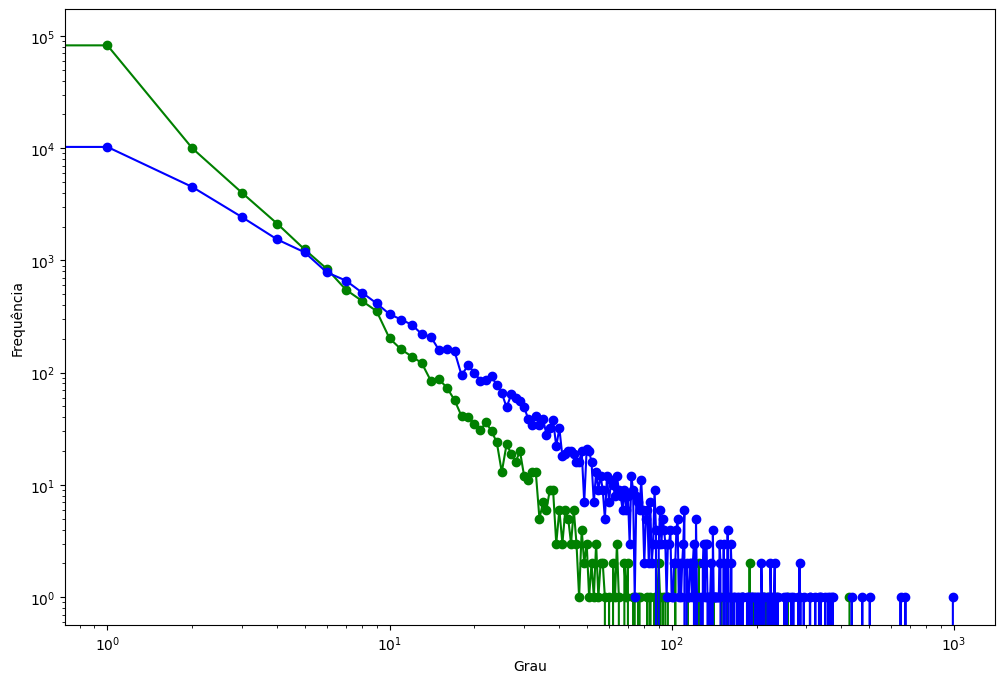

In [ ]:
in_degree_freq = degree_histogram_directed(G, in_degree=True)
out_degree_freq = degree_histogram_directed(G, out_degree=True)
degrees = range(len(in_degree_freq))
plt.figure(figsize=(12, 8)) 
plt.loglog(range(len(in_degree_freq)), in_degree_freq, 'go-', label='in-degree') 
plt.loglog(range(len(out_degree_freq)), out_degree_freq, 'bo-', label='out-degree')
plt.xlabel('Grau')
plt.ylabel('Frequência')
plt.show()


In [ ]:
in_degree_freq = degree_histogram_directed(subG, in_degree=True)
out_degree_freq = degree_histogram_directed(subG, out_degree=True)
degrees = range(len(in_degree_freq))
plt.figure(figsize=(12, 8)) 
plt.loglog(range(len(in_degree_freq)), in_degree_freq, 'go-', label='in-degree') 
plt.loglog(range(len(out_degree_freq)), out_degree_freq, 'bo-', label='out-degree')
plt.xlabel('Grau')
plt.ylabel('Frequência')
plt.show()


NameError: name 'subG' is not defined

In [ ]:
degrees = []

for node in G.nodes():
    degrees.append(nx.degree(G, node))

print(f"Nº de nós: {G.number_of_nodes()}")
print(f"Nº de links: {G.number_of_edges()}")
print(f"Grau médio: {np.mean(degrees)}")
print(f"Densidade: {nx.density(G)}")
# print(f"Distância média: {nx.average_shortest_path_length(G)}")
print(f"Cluster global: {nx.transitivity(G)}")
print(f"Cluster médio: {nx.average_clustering(G)}")
# print(f'Coeficiente de assortatividade geral: {nx.degree_assortativity_coefficient(G)}')

# print(f'Coeficiente de centralidade de grau: {nx.degree_centrality(G)}')
# print(f'Coeficiente de centralidade de proximidade: {nx.closeness_centrality(G)}')
# print(f'Coeficiente de centralidade de betweeness: {nx.betweenness_centrality(G)}')

Nº de nós: 123532
Nº de links: 174656
Grau médio: 2.827704562380598
Densidade: 1.1445323693569217e-05
Cluster global: 0.0027003891924078133
Cluster médio: 0.01425055979640796


In [ ]:
# Gerando um subgrafo com o maior componente conexo
componentes = nx.weakly_connected_components(G)
maior_componente = max(componentes, key=len)
G2 = G.subgraph(maior_componente)

In [ ]:
degreesSubgraph = []

for node in G2.nodes():
    degreesSubgraph.append(nx.degree(G2, node))

print(f"Nº de nós: {G2.number_of_nodes()}")
print(f"Nº de links: {G2.number_of_edges()}")
print(f"Grau médio: {np.mean(degreesSubgraph)}")
print(f"Densidade: {nx.density(G2)}")
# print(f"Distância média: {nx.average_shortest_path_length(G)}")
print(f"Cluster global: {nx.transitivity(G2)}")
print(f"Cluster médio: {nx.average_clustering(G2)}")
# print(f'Coeficiente de assortatividade geral: {nx.degree_assortativity_coefficient(subG)}')

# print(f'Coeficiente de centralidade de grau: {nx.degree_centrality(subG)}')
# print(f'Coeficiente de centralidade de proximidade: {nx.closeness_centrality(subG)}')
# print(f'Coeficiente de centralidade de betweeness: {nx.betweenness_centrality(subG)}')

Nº de nós: 89100
Nº de links: 150212
Grau médio: 3.3717620650953983
Densidade: 1.892143607164726e-05
Cluster global: 0.0027184877049644947
Cluster médio: 0.019059786280522236


In [ ]:
centrality = nx.algorithms.degree_centrality(G)
nx.set_node_attributes(G, centrality, 'size')

communities = nx.algorithms.community.girvan_newman(G)

In [ ]:
fluidCommunities = nx.algorithms.community.asyn_fluidc(G, 500)

In [ ]:
centrality = nx.algorithms.degree_centrality(G)
nx.set_node_attributes(G, centrality, 'size')

communities = nx.algorithms.community.louvain_communities(G)
colors = ['red', 'blue', 'green', 'orange', 'pink']
for community, color in zip(communities, colors):
    for node in community:
        G.nodes[node]['color'] = color

fig = gv.d3(G, use_node_size_normalization=True, node_size_normalization_max=30,
            use_edge_size_normalization=True, edge_size_data_source='weight', edge_curvature=0.3,
            zoom_factor=0.6)

fig.savefig(r'E://graph.png')

AttributeError: 'Figure' object has no attribute 'savefig'

In [ ]:
centrality = nx.algorithms.degree_centrality(G2)
nx.set_node_attributes(G, centrality, 'size')

communities = nx.algorithms.community.louvain_communities(G2)
colors = ['red', 'blue', 'green', 'orange', 'pink']
for community, color in zip(communities, colors):
    for node in community:
        G.nodes[node]['color'] = color

fig = gv.d3(G2, use_node_size_normalization=True, node_size_normalization_max=30,
            use_edge_size_normalization=True, edge_size_data_source='weight', edge_curvature=0.3,
            zoom_factor=0.6)

In [ ]:
fig.display()

In [ ]:
# export the graph as txt
nx.write_edgelist(G, "D:\\Documentos\\data_and_code\\all_data_lisbon\\graphWithCoords.txt", data=False)

In [26]:
# load graph from edgelist txt file
G = nx.read_edgelist("D:\\Documentos\\data_and_code\\all_data_lisbon\\graphWithCoords.txt", create_using=nx.DiGraph())

In [ ]:
pos = nx.spring_layout(G)  # Posições dos nós
nx.draw(G, pos, with_labels=True, node_size=500, node_color='skyblue', font_size=10, font_color='black', arrows=True)
plt.savefig("D:\\Documentos\\data_and_code\\all_data_lisbon\\graph.png", dpi=300, bbox_inches='tight')
plt.show()


KeyboardInterrupt: 

In [17]:
def calculateDistance(xP1: float, yP1: float, xP2: float, yP2: float):
    P1 = [xP1, yP1]
    P2 = [xP2, yP2]
    
    return math.dist(P1, P2)

In [18]:
def calculateDistances(graph, generalizationLimit = None):
  nodes_with_median = [node for node in graph.nodes if "median_X" in graph.nodes[node]]
  
  print(f"Existem {len(nodes_with_median)} nós com mediana.")
  
  distances = {}
  
  for node in tqdmBasic(nodes_with_median):
    for other_node in nodes_with_median:
        if node == other_node:
            continue
        
        # print(f"Calculando distância entre {node} e {other_node}")
        
        distance = calculateDistance(
            graph.nodes[node]["median_X"], graph.nodes[node]["median_Y"], graph.nodes[other_node]["median_X"], graph.nodes[other_node]["median_Y"]
        )
        if generalizationLimit is not None:
            generaralized_distance = int(distance//generalizationLimit)
            if generaralized_distance not in distances.keys():
                distances[generaralized_distance] = 1
            else:
                distances[generaralized_distance] += 1
        else:
            if distance not in distances.keys():
                distances[distance] = 1
            else:
                distances[distance] += 1
            
        # distancesFromNode[node].append(distance)
  
  
  return distances
  
  # distances = {}
  # for node in tqdmBasic(graph.nodes, total=graph.number_of_nodes()):
  #   if not "median_X" in graph.nodes[node]:
  #     continue

  #   distances[node] = []
  #   for other_node in graph.nodes():
  #     if node == other_node:
  #       continue

  #     if not "median_X" in graph.nodes[other_node]:
  #       continue

  #     distance = calculateDistance(
  #         graph.nodes[node]["median_X"], graph.nodes[node]["median_Y"], graph.nodes[other_node]["median_X"], graph.nodes[other_node]["median_Y"]
  #     )

  #     distances[node].append(distance)

  # # Calcula a matriz de distâncias.
  # distance_matrix = np.zeros((graph.number_of_nodes(), graph.number_of_nodes()))
  # for node in distances:
  #   for other_node in distances[node]:
  #     distance_matrix[node, other_node] = distances[node][other_node]

  # # Ordena a matriz de distâncias.
  # distance_matrix = np.sort(distance_matrix, axis=1)

  # return distance_matrix

In [ ]:
# create an empty graph
G = nx.Graph()

# add nodes to the graph
for user in list(df_mean['username']):
    G.add_node(user)

#connect all the nodes with each other
for user1 in tqdmBasic(list(df_mean['username']), total=len(list(df_mean['username']))):
    for user2 in list(df_mean['username']):
        if user1 == user2:
            continue
        
        if G.has_edge(user1, user2) or G.has_edge(user2, user1):
            continue
        
        G.add_edge(user1, user2)

# print the graph
print(G.number_of_nodes())
print(G.number_of_edges())


  2%|▏         | 2730/116088 [09:17<7:59:47,  3.94it/s] 

In [ ]:
print(list(G.nodes())[:20])


['Manuela_Lagoa', 'oblogdoedinho', 'noventaradio', 'object82', 'Itsmarsousa', 'dezanovept', 'caco_palmela', 'AlexDaSilva', 'gomesduds', 'maumaub', 'HMeMarques', 'MicaelSS', 'lpoeirass', 'akynos', 'Mad7er7', 'k4rdz', 'bh_thamy', 'ricoonn', 'MaurelioFama', 'raquel_cbento']


In [32]:
# add the 'value' attribute to each node
mean_X = dict(zip(df_mean['username'], df_mean['mean_X']))
mean_Y = dict(zip(df_mean['username'], df_mean['mean_Y']))
median_X = dict(zip(df_mean['username'], df_mean['median_X']))
median_Y = dict(zip(df_mean['username'], df_mean['median_Y']))
nx.set_node_attributes(G, mean_X, 'mean_X')
nx.set_node_attributes(G, mean_Y, 'mean_Y')
nx.set_node_attributes(G, median_X, 'median_X')
nx.set_node_attributes(G, median_Y, 'median_Y')
# del mean_X, mean_Y, median_X, median_Y

In [43]:
G2 = G.copy()

nodes_without_attributes = [node for node in G.nodes() if not G.nodes[node]]
G2.remove_nodes_from(nodes_without_attributes)


In [46]:
degreesSubgraph = []

for node in G2.nodes():
    degreesSubgraph.append(nx.degree(G2, node))

print(f"Nº de nós: {G2.number_of_nodes()}")
print(f"Nº de links: {G2.number_of_edges()}")
print(f"Grau médio: {np.mean(degreesSubgraph)}")
print(f"Densidade: {nx.density(G2)}")
# print(f"Distância média: {nx.average_shortest_path_length(G)}")
print(f"Cluster global: {nx.transitivity(G2)}")
print(f"Cluster médio: {nx.average_clustering(G2)}")

Nº de nós: 28387
Nº de links: 22584
Grau médio: 1.591150878923451
Densidade: 2.8027035843786565e-05
Cluster global: 0.03540733991571975
Cluster médio: 0.018583207004925214


In [33]:
del mean_X, mean_Y, median_X, median_Y


In [22]:
# iterate over all edges
for u, v in tqdmBasic(G.edges(), total=G.number_of_edges()):
    # print(f"Calculando distância entre {u} e {v}")
    # print(f"Coordenadas de {u}: {G.nodes[u]['median_X']}, {G.nodes[u]['median_Y']}")
    # print(f"Coordenadas de {v}: {G.nodes[v]['median_X']}, {G.nodes[v]['median_Y']}")
    # break
    if 'median_X' not in G.nodes[u] or 'median_X' not in G.nodes[v]:
        continue
    
    # get the median_X and median_Y of the nodes
    xP1, yP1 = G.nodes[u]['median_X'], G.nodes[u]['median_Y']
    xP2, yP2 = G.nodes[v]['median_X'], G.nodes[v]['median_Y']
    
    # calculate the distance between the nodes
    distance = calculateDistance(xP1, yP1, xP2, yP2)
    
    # set the edge attribute as the distance
    G.edges[u, v]['distance'] = distance
    # print(f"Distância entre {u} e {v}: {distance}")
    # break


100%|██████████| 174656/174656 [00:00<00:00, 949007.04it/s]


In [21]:
del author_id_to_username, fp

In [ ]:
for u, v in G.edges:
    print(G.nodes[u]['median_X'])
    break

In [23]:
distancesToEveryOther = calculateDistances(G)

Existem 28387 nós com mediana.


100%|██████████| 28387/28387 [34:23<00:00, 13.76it/s]   


In [29]:
with open("E://distances_to_every_other_node.json", "w") as outfile: 
    json.dump(distancesToEveryOther, outfile)

In [17]:
with open('E://distances_to_every_other_node.json', 'r') as f:
    distancesToEveryOther = json.load(f)

In [15]:
# import json

# Read the JSON file
with open('E://distances_to_every_other_node_10km.json', 'r') as f:
    data = json.load(f)

# Create a dictionary from the JSON data
distancesToEveryOther = dict(data)

# Print the dictionary
print(distancesToEveryOther)


{'0': 348132998, '1': 233338304, '2': 136015316, '4': 17878838, '3': 64722740, '5': 4706264, '6': 942580, '7': 56178, '8': 164}


In [15]:
print(f"{len(distancesToEveryOther):,}")

9


In [25]:
print(distancesToEveryOther)

{0: 348132998, 1: 233338304, 2: 136015316, 4: 17878838, 3: 64722740, 5: 4706264, 6: 942580, 7: 56178, 8: 164}


In [ ]:
distancesToEveryOtherUnique = list(set(distancesToEveryOther))

In [ ]:
count = 0
for node in G.nodes():
    if G.nodes[node]:
        count += 1
print(f"Number of nodes with attributes: {count}")


Number of nodes with attributes: 28387


In [1]:
print(G.number_of_nodes())

NameError: name 'G' is not defined

In [ ]:
# gerar um array em P.A.
# [1 - i/n for i in range(0,n)]
# [1 - (i+1)/n for i in range(0,n)]

my_dict = {'a': 3, 'b': 2, 'c': 4}

my_list = [key for key, value in my_dict.items() for _ in range(value)]

print(my_list)


In [41]:
def plotScatterEmpyricalComplementarDistribution(distances, output_path: str = 'E://', output_file_name: str = 'empyrical_complementar_distribution.png', show: bool = False, log: bool = False):
    """Plota o gráfico de dispersão da distribuição empírica complementar.

    Args:
        distances (list): Lista com as distâncias.
        output_path (str): Caminho de saída do arquivo.
        output_file_name (str): Nome do arquivo de saída.
        show (bool): Se o gráfico deve ser exibido.
    """    
    # sort the distances

    # calculate the probability of each distance
    if isinstance(distances, dict):
        keys_in_order = sorted(distances.keys())
        length_distances = sum(distances.values())
        dist = 1
        prob = []
        print(f"keys_in_order: {keys_in_order}")
        print(f"length_distances: {length_distances}")
        
        distances_list = [key for key, value in distances.items() for _ in tqdmBasic(range(value))]
        n = len(distances_list)
        prob = [1 - (i+1)/n for i in tqdmBasic(range(0,n))]
                    
        distances = list(distances.keys())
        
    else:
        distances.sort()
        if log == True:
            prob = [np.log10(1 - (i/len(distances))) for i in tqdmBasic(range(len(distances)), desc="Calculando probabilidade")]
        else:
            prob = [1 - (i/len(distances)) for i in tqdmBasic(range(len(distances)))]
            
    print(type(prob))

    # plot the scatter graph
    plt.figure(figsize=(180, 120))
    plt.scatter(distances, prob)
    plt.yticks(np.arange(0, 1.1, 0.1))
    plt.xlabel("Distância")
    plt.ylabel("Probabilidade")
    plt.savefig(f"{output_path}{output_file_name}", dpi=300, bbox_inches='tight')
    
    if show:
        plt.show()
       
    

In [24]:
# extract the distances from the edges
distances = []

for u, v in G.edges():
    if 'distance' in G.edges[u, v]:
        distances.append(G.edges[u, v]['distance'])
        
    

In [ ]:
distancesNo0 = [distance for distance in distances if distance != 0.0]
logDistances = [np.log10(distance) for distance in distances]
logDistancesNo0 = [np.log10(x) for x in distancesNo0]


C:\Users\Cliente\AppData\Local\Temp\ipykernel_22276\3683328142.py:2: RuntimeWarning: divide by zero encountered in log10
  logDistances = [np.log10(distance) for distance in distances]


In [25]:
distancesToEveryOtherList = [key for key, value in distancesToEveryOther.items() for _ in range(value)]

In [30]:
with open('E://lista_distancias_todos_vértices.json', 'w') as file:
    json.dump(distancesToEveryOtherList, file)


In [26]:
distancesToEveryOtherList.sort()

In [27]:
filtered_distances_to_every_other = [distance for i, distance in tqdmBasic(enumerate(distancesToEveryOtherList), total=805793382) if int(distance) % 1000 == 0]


100%|██████████| 805793382/805793382 [05:19<00:00, 2519328.95it/s]


In [28]:
filtered_distances_to_every_other[len(filtered_distances_to_every_other)-1]

78000.3989097619

In [30]:
filtered_distances = [distance for distance in tqdmBasic(distances) if int(distance) % 1000 == 0]

100%|██████████| 22584/22584 [00:00<00:00, 2822195.25it/s]


In [33]:
prob_all_distances = [1 - (i+1)/len(filtered_distances_to_every_other) for i in tqdmBasic(range(0,len(filtered_distances_to_every_other)))]
prob_connected_distances = [1 - (i+1)/len(filtered_distances) for i in tqdmBasic(range(0,len(filtered_distances)))]

100%|██████████| 2273/2273 [00:00<00:00, 2273164.76it/s]


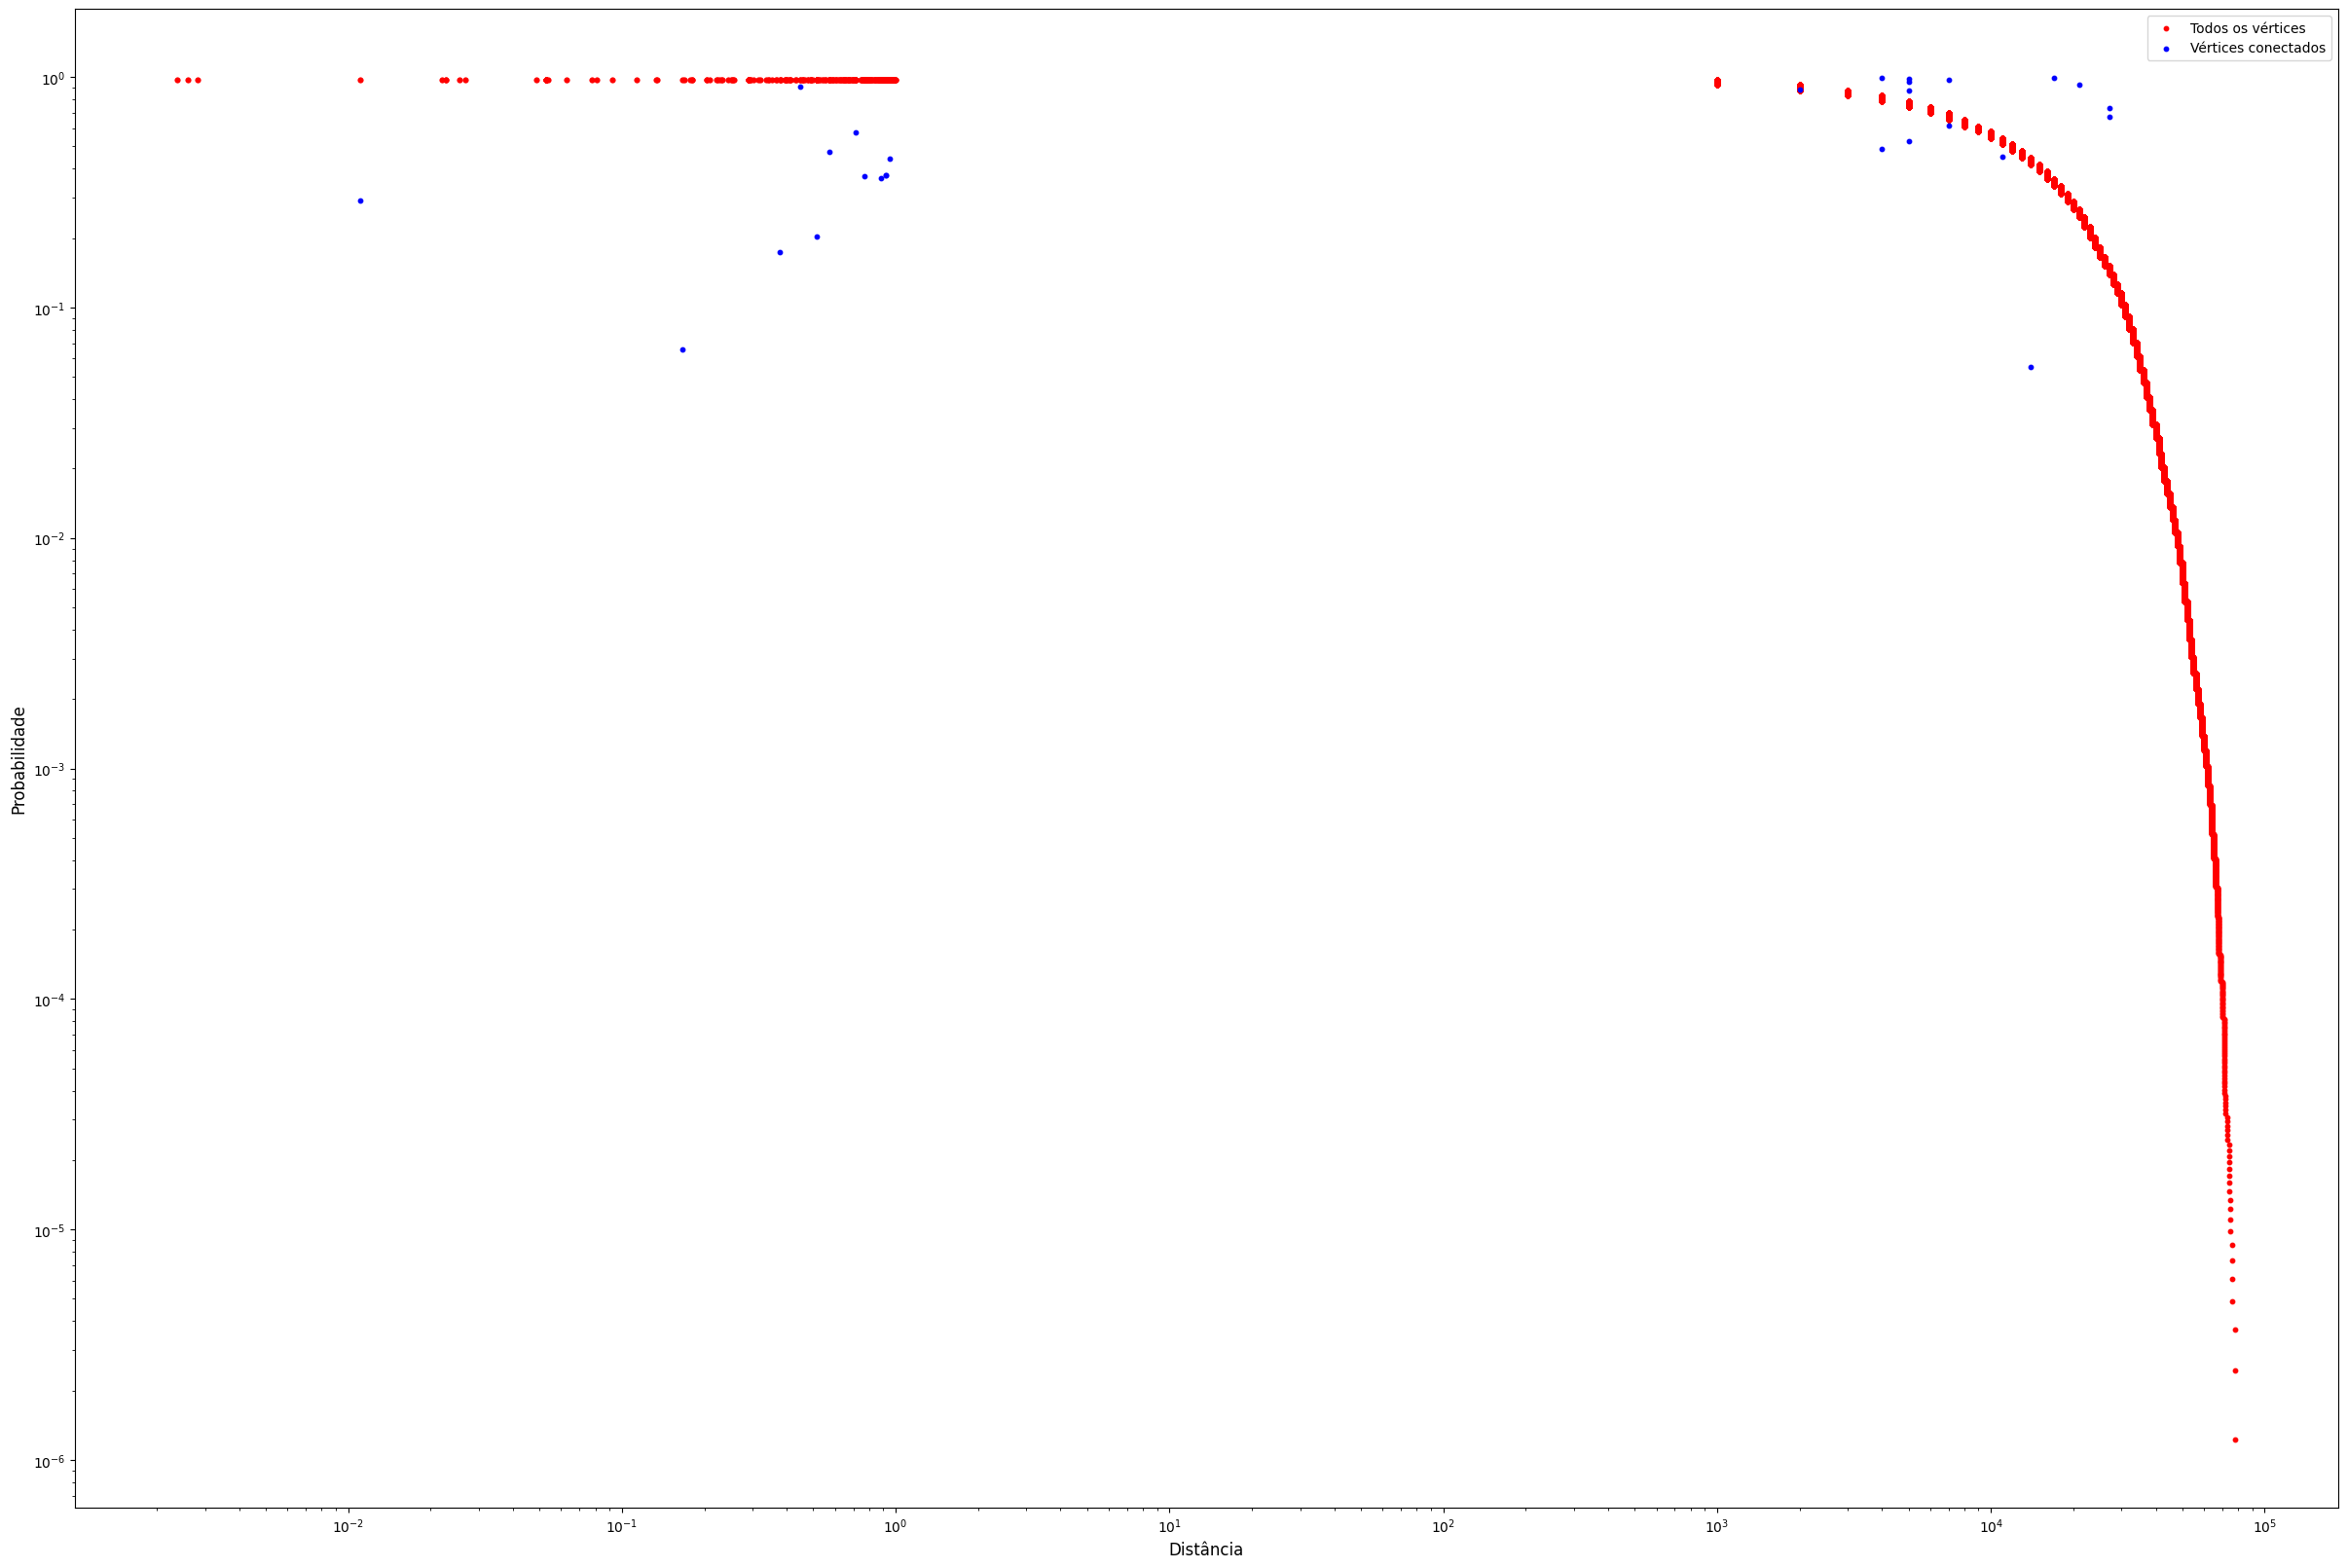

In [45]:
plt.figure(figsize=(30, 20))

# Scatter plot
plt.scatter(filtered_distances_to_every_other, prob_all_distances, label='Todos os vértices', color='red', s=10)
plt.scatter(filtered_distances, prob_connected_distances, label='Vértices conectados', color='blue', s=10)

# Set scale to log
plt.xscale('log')
plt.yscale('log')

# Set labels and title
plt.xlabel('Distância', fontsize=12)
plt.ylabel('Probabilidade', fontsize=12)
plt.legend()

# Show the plot
plt.show()


In [71]:
# plotScatterEmpyricalComplementarDistribution(distances, output_path='E://', output_file_name='Distribuição de distâncias de nós ligados .png', show=False)
# plotScatterEmpyricalComplementarDistribution(distancesNo0, output_path='E://', output_file_name='Distribuição de distâncias de nós ligados sem distância 0.png')
# plotScatterEmpyricalComplementarDistribution(logDistances, output_path='E://', output_file_name='Distribuição de distâncias de nós ligados (log).png')
# plotScatterEmpyricalComplementarDistribution(logDistancesNo0, output_path='E://', output_file_name='Distribuição de distâncias de nós ligados (log) sem distância 0.png')
# plotScatterEmpyricalComplementarDistribution(logDistances, output_path='E://', output_file_name='Distribuição de distâncias de nós ligados (log-log).png', log=True)
# plotScatterEmpyricalComplementarDistribution(logDistancesNo0, output_path='E://', output_file_name='Distribuição de distâncias de nós ligados (log-log) sem distância 0.png', log=True)
plotScatterEmpyricalComplementarDistribution(filtered_distances, output_path='E://', output_file_name='Distribuição de distâncias de nós (10m).png', log=True)
# plotScatterEmpyricalComplementarDistribution(distancesToEveryOtherNo0, output_path='E://', output_file_name='Distribuição de distâncias de nós sem distância 0.png', log=True)

Calculando probabilidade: 100%|██████████| 80624836/80624836 [01:38<00:00, 816403.73it/s]


<class 'list'>


MemoryError: 

In [34]:
distancesToEveryOtherList.sort()

In [37]:
len(filtered_distances)

80579

In [35]:
probabilities = [1 - (i+1)/len(distancesToEveryOtherList) for i in tqdmBasic(range(0,len(distancesToEveryOtherList)))]

 96%|█████████▌| 773136844/805793382 [04:15<00:10, 3020818.06it/s]


MemoryError: 

In [ ]:
cc = nx.clustering(G)

chave = " "
for k, v in cc.items():
    if chave == " ":
        chave = k
    if v > cc[chave]:
        chave = k
        
print(chave, cc[chave])

In [ ]:
print(len(Y))

In [ ]:
print(max(nodeClusterCoef))

In [ ]:
# Create a log-log histogram of the cumulative frequency of the local clustering coefficient of the nodes of the graph
nodeClusterCoef = list(nx.clustering(G).values())
# hist, bins = np.histogram(nodeClusterCoef, bins=100)
nodeClusterCoef.sort()
nodeClusterCoef = [i for i in nodeClusterCoef if i != 1]
# cumulativeFreq = np.cumsum(hist)
# maxCumulativeFreq = max(cumulativeFreq)

# inverseCumulativeFreq = [ maxCumulativeFreq - i for i in cumulativeFreq]

Y = np.linspace(len(nodeClusterCoef), 1, num=len(nodeClusterCoef))
X = nodeClusterCoef

plt.figure(figsize=(12, 8))
plt.plot(np.log(X), np.log(Y), 'bo-')
plt.xlabel('Clustering coefficient')
plt.ylabel('Cumulative frequency')
plt.show()

In [ ]:
print(nodeClusterCoefSubGrafo)

In [ ]:
nodeClusterCoefSubGrafo = list(nx.clustering(G2).values())
# hist, bins = np.histogram(nodeClusterCoef, bins=100)
# cumulativeFreq = np.cumsum(hist)

# inverseCumulativeFreq = [ maxCumulativeFreq - i for i in cumulativeFreq]


# plt.figure(figsize=(12, 8))
# plt.loglog(bins[:-1], inverseCumulativeFreq, 'go-')
# plt.xlabel('Clustering coefficient')
# plt.ylabel('Cumulative frequency')
# plt.show()

C:\Users\Cliente\AppData\Local\Temp\ipykernel_15984\2719714839.py:26: RuntimeWarning: divide by zero encountered in log
  plt.scatter(np.log(nodeClusterCoef), logDegrees, s=10, c='g')


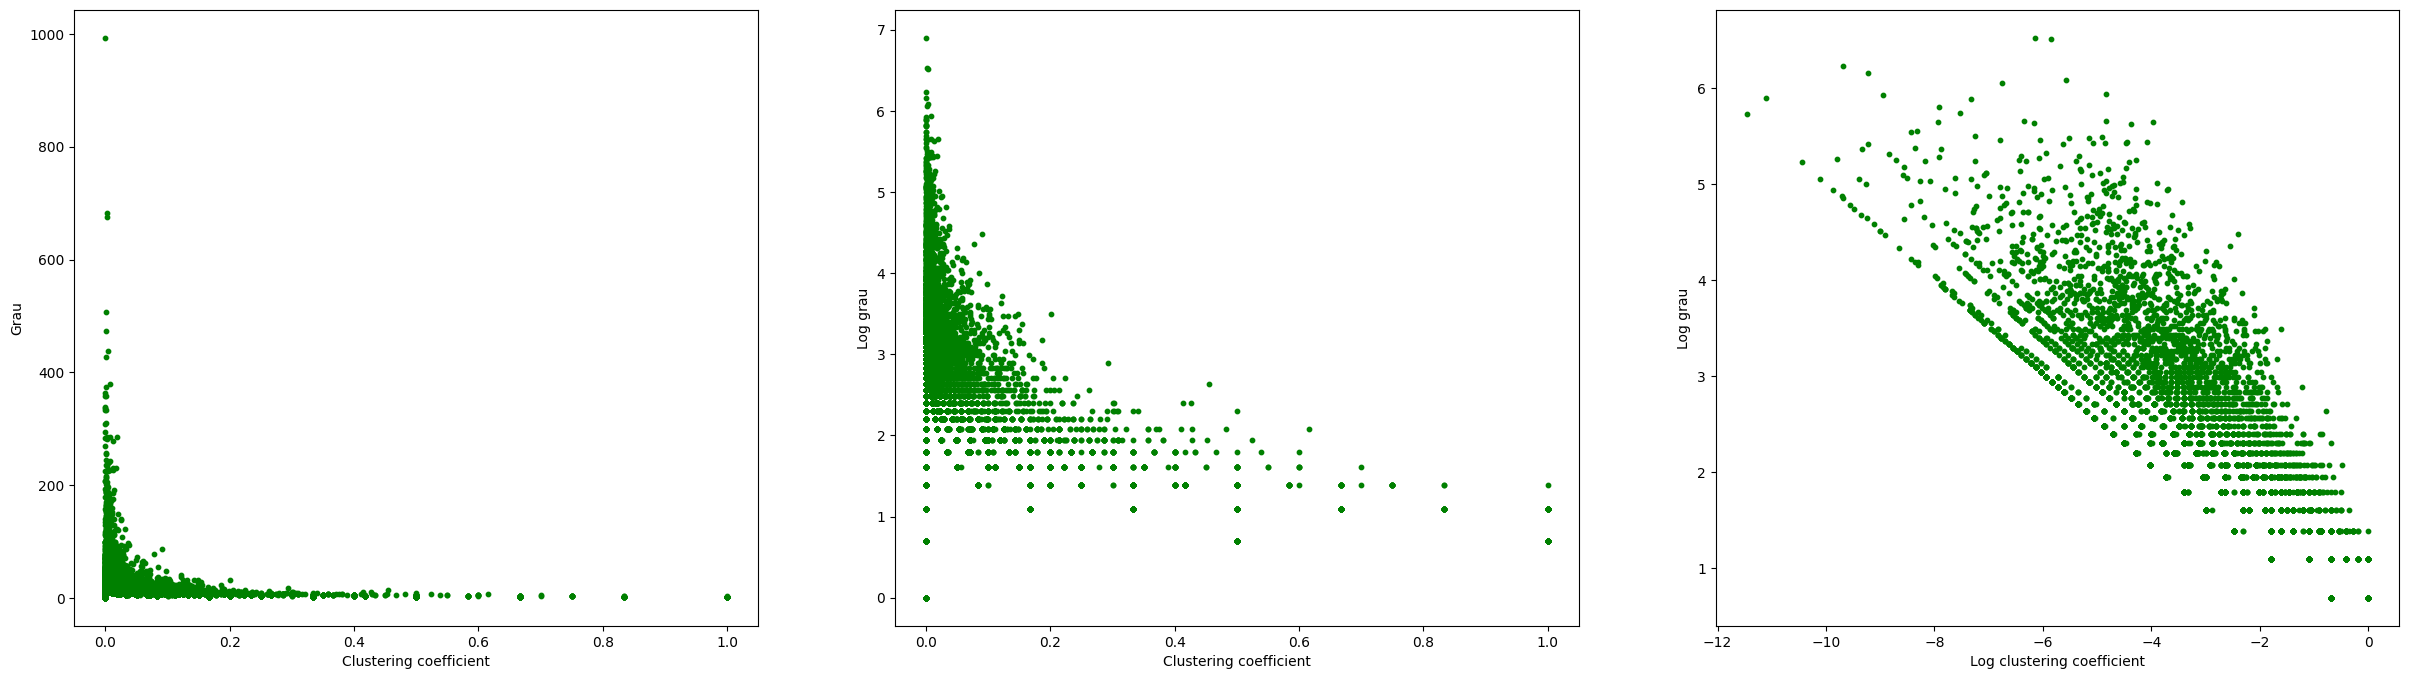

In [ ]:
# draw a scatter plot of the degree of the nodes of the graph versus their local clustering coefficient
degrees = []
logDegrees = []

for node in G.nodes():
    degrees.append(nx.degree(G, node))
    
for node in G.nodes():
    logDegrees.append(np.log(nx.degree(G, node)))
    
fig = plt.figure(figsize=(30, 8))

ax = fig.add_gridspec(1, 3)
    
ax1 = fig.add_subplot(ax[0, 0])
plt.scatter(nodeClusterCoef, degrees, s=10, c='g')
plt.ylabel('Grau')
plt.xlabel('Clustering coefficient')

ax2 = fig.add_subplot(ax[0, 1])
plt.scatter(nodeClusterCoef, logDegrees, s=10, c='g')
plt.ylabel('Log grau')
plt.xlabel('Clustering coefficient')

ax3 = fig.add_subplot(ax[0, 2])
plt.scatter(np.log(nodeClusterCoef), logDegrees, s=10, c='g')
plt.ylabel('Log grau')
plt.xlabel('Log clustering coefficient')
plt.show()

In [ ]:
degreesSubg = []
logDegreesSubg = []

for node in G2.nodes():
    degreesSubg.append((nx.degree(G2, node)))
    
for node in G2.nodes():
    logDegreesSubg.append(np.log(nx.degree(G2, node)))

fig = plt.figure(figsize=(30, 8))

ax = fig.add_gridspec(1, 3)    

ax1 = fig.add_subplot(ax[0, 0])
plt.scatter((nodeClusterCoefSubGrafo), degreesSubg, s=10, c='g')
plt.ylabel('Grau')
plt.xlabel('Clustering coefficient')

ax2 = fig.add_subplot(ax[0, 1])
plt.scatter((nodeClusterCoefSubGrafo), logDegreesSubg, s=10, c='g')
plt.ylabel('Log grau')
plt.xlabel('Clustering coefficient')

ax3 = fig.add_subplot(ax[0, 2])
plt.scatter(np.log(nodeClusterCoefSubGrafo), logDegreesSubg, s=10, c='g')
plt.ylabel('Log grau')
plt.xlabel('Log clustering coefficient')

plt.show()

In [ ]:
plt.savefig("D:\\Documentos\\data_and_code\\all_data_lisbon\\plot_degree_clustering.png", dpi=300)


In [ ]:
usuarioUnicos = dfMencoes['author_id'].unique()

In [ ]:
# Desenhe o grafo
pos = nx.spring_layout(G2)
nx.draw_networkx_nodes(G2, pos, cmap=plt.get_cmap('jet'), node_size = 500)
nx.draw_networkx_labels(G2, pos)
nx.draw_networkx_edges(G2, pos, edge_color='r', arrows=True)
nx.draw_networkx_edges(G2, pos, arrows=False)
plt.show()

In [ ]:
seed = 13648  # Seed random number generators for reproducibility
pos = nx.spring_layout(G, seed=seed)

node_sizes = [3 + 10 * i for i in range(len(G))]
M = G.number_of_edges()
edge_colors = range(2, M + 2)
edge_alphas = [(5 + i) / (M + 4) for i in range(M)]
cmap = plt.cm.plasma

nodes = nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color="indigo")
edges = nx.draw_networkx_edges(
    G,
    pos,
    node_size=node_sizes,
    arrowstyle="->",
    arrowsize=10,
    edge_color=edge_colors,
    edge_cmap=cmap,
    width=2,
)
# set alpha value for each edge
for i in range(M):
    edges[i].set_alpha(edge_alphas[i])

pc = mpl.collections.PatchCollection(edges, cmap=cmap)
pc.set_array(edge_colors)

ax = plt.gca()
ax.set_axis_off()
plt.colorbar(pc, ax=ax)
plt.show()

In [ ]:
dictUsuarios = {}
cont = 0
for user in usuarioUnicos:
    cont += 1
    dictUsuarios[user] = dfMencoes.loc[dfMencoes['author_id'] == user]['usuario'].values[0]
    print(cont)
    

In [ ]:
dictUsuarios

In [ ]:
i = 1
for index, row in dfMencoes.iterrows():
    clear_output(wait=True)
    display('Iteration '+str(i)+' of '+str(dfMencoes.shape[0]))
    dfMencoes['usuario'] = dictUsuarios[row['author_id']]
    i += 1

In [ ]:
dfMencoes.to_json(r'D:\\Documentos\\data_and_code\\all_data_lisbon\\mentionsWithUserNames.jsonl', orient='records', lines=True)

In [ ]:
dfMencoesComUserName.to_json(r'D:\\Documentos\\data_and_code\\all_data_lisbon\\mentionsWithUserNames.jsonl', orient='records', lines=True)

In [ ]:
dataFrameComUsernames.to_json(r'E:\\data_com_usernames_30k.jsonl', orient='records', lines=True)

In [ ]:
teste1 = data_frame['entities_mentions']
teste1.dropna(inplace=True)
# teste1.reset_index(drop=True, inplace=True)
teste1 = teste1.to_frame()
teste1


In [ ]:
# print(mention['username'] for mention in teste1.at[0])
# print(data['entities_mentions'].at[2350])
# print(teste1.at[2350])

mentionsUsuario = {}

# Percorrendo teste1 e adicionando os usernames no dicionário usando o id do usuário como chave
    
contador = 1
for mention in teste1.itertuples():
    print(f"Mention {contador} de {teste1.shape[0]}")
    
    usuariosMencionados = []
    if data_frame['author_id'].at[mention.Index] not in mentionsUsuario:
        mentionsUsuario[data_frame['author_id'].at[mention.Index]] = []
        
    for usuario in mention[1]:
        usuariosMencionados.append(usuario['username'])
        # print(usuario['username'])
        mentionsUsuario[data_frame['author_id'].at[mention.Index]].extend(usuariosMencionados)
    contador += 1

In [ ]:
# para cada lista de usuários mencionados, remover os usuários repetidos
mentionsUsuario = {k: list(dict.fromkeys(v)) for k, v in mentionsUsuario.items()}

print(mentionsUsuario)

In [ ]:
len(mentionsUsuario)

In [ ]:
mentionsUnicas = geraDictMentionsByUser(data_frame)
mentionsNaoUnicas = geraDictMentionsByUser(data_frame, False)

In [ ]:
print(f"Média das mentions sem usuário repetido: {returnMediaDictListas(mentionsUnicas)}")
print(f"Média das mentions com usuário repetido: {returnMediaDictListas(mentionsNaoUnicas)}")

In [ ]:
idsPerfisUnicos : list
mentions: list
usuariosMencionados: list
tweetsComLinkEncurtado: list

# Recuperando uma lista com os valores únicos da coluna author_id
idsPerfisUnicos = data_frame['author_id'].unique().tolist()

# Recuperando uma lista com os valores não-nulos da coluna entities_mentions
# mentions = data['entities_mentions']
# mentions.dropna(inplace=True)
# mentions.reset_index(drop=True, inplace=True)

# # Recuperando uma lista com os valores não-nulos e únicos das mentions
# usersMencionados = [user for user in mentions[0].at[0] if user['username'] not in usersMencionados]

# # Recuperando uma lista com os valores não-nulos e únicos da coluna entities_annotations
# annotationsUnicas = data['context_annotations'].dropna().unique()


In [ ]:
mencoesSet = set()

for lista in mentionsUnicas.values():
    mencoesSet.update(lista)
    
usuariosMencionados = list(mencoesSet)

In [ ]:
print(f'Quantidade de perfis únicos: {len(idsPerfisUnicos)}')
print(f'Quantidade de perfis mencionados: {len(usuariosMencionados)}')

In [ ]:
dfExportUsuariosMencionados = pd.DataFrame(usuariosMencionados, columns=['username'])
dfExportUsuariosMencionados.to_csv(r'D:\\Documentos\\data_and_code\\all_data_lisbon\\usuariosMencionados.csv', index=False)

In [ ]:
teste2 = data_frame['entities_annotations']
teste2.dropna(inplace=True)
teste2.to_frame()

teste2.shape[0]

In [ ]:
teste2.to_csv(r'D:\\Documentos\\data_and_code\\all_data_lisbon\\teste2.csv', index=False)

In [24]:
df_mean = df_mean.drop(index=0)

df_mean.head()

,username,mean_lat,mean_lon,median_lat,median_lon,mean_X,mean_Y,median_X,median_Y
1,Manuela_Lagoa,38.7,-9.18333333,38.7,-9.18333333,484058.0201695964,4283502.065548434,484058.0201695964,4283502.065548434
2,oblogdoedinho,38.72556305044776,-9.150001534925371,38.72556305,-9.15000153,486961.0744357934,4286333.415443861,486961.0748638524,4286333.415393474
3,noventaradio,38.86226743322353,-9.065096915696257,38.86485962,-9.06072863,494352.23164528405,4301494.446264396,494731.4127623029,4301781.836199852
4,object82,38.75138141069397,-9.188555476450512,38.7167,-9.1569,483615.65982184716,4289204.575585471,486359.7383995273,4285350.924191058
5,Itsmarsousa,38.650378758920446,-9.074262791420454,38.66137,-9.07744,493537.9279843213,4277982.518656515,493262.48875507596,4279202.385287764


In [25]:
X=df_mean.loc[:,['username','median_lat','median_lon']]
X.head(10)

,username,median_lat,median_lon
1,Manuela_Lagoa,38.7,-9.18333333
2,oblogdoedinho,38.72556305,-9.15000153
3,noventaradio,38.86485962,-9.06072863
4,object82,38.7167,-9.1569
5,Itsmarsousa,38.66137,-9.07744
6,dezanovept,38.7128,-9.14637322
7,caco_palmela,38.57453305,-8.94689441
8,AlexDaSilva,38.73843828,-9.17067
9,gomesduds,38.7261,-9.15913394
10,maumaub,38.7019934,-9.3454893


In [27]:
print(X.dtypes)


username      object
median_lat    object
median_lon    object
dtype: object


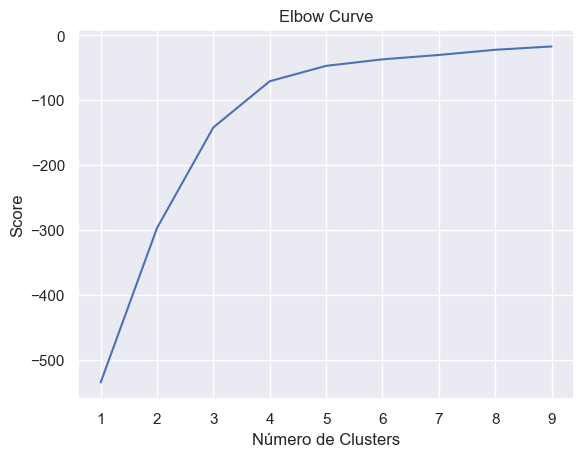

In [28]:
K_clusters = range(1,10)
kmeans = [KMeans(n_clusters=i) for i in K_clusters]

Y_axis = X[['median_lat']]
X_axis = X[['median_lon']]

score = [kmeans[i].fit(Y_axis).score(Y_axis) for i in range(len(kmeans))]

#Visualize
plt.plot(K_clusters, score)
plt.xlabel('Número de Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show()

In [30]:
kmeans = KMeans(n_clusters=4, init='k-means++')
kmeans.fit(X[X.columns[1:4]].drop('cluster_label', axis=1)) # Compute k-means clustering.

X['cluster_label'] = kmeans.fit_predict(X[X.columns[1:4]])
centers = kmeans.cluster_centers_ # Coordinates of cluster centers.

labels = kmeans.predict(X[X.columns[1:4]]) # Labels of each point

X.head(10)

,username,median_lat,median_lon,cluster_label
1,Manuela_Lagoa,38.7,-9.18333333,0
2,oblogdoedinho,38.72556305,-9.15000153,0
3,noventaradio,38.86485962,-9.06072863,3
4,object82,38.7167,-9.1569,0
5,Itsmarsousa,38.66137,-9.07744,0
6,dezanovept,38.7128,-9.14637322,0
7,caco_palmela,38.57453305,-8.94689441,2
8,AlexDaSilva,38.73843828,-9.17067,0
9,gomesduds,38.7261,-9.15913394,0
10,maumaub,38.7019934,-9.3454893,1


In [ ]:
X.to_csv(r'D:\\Documentos\\data_and_code\\all_data_lisbon\\usuariosComClusters.csv', index=False)

TypeError: 'value' must be an instance of str or bytes, not a float

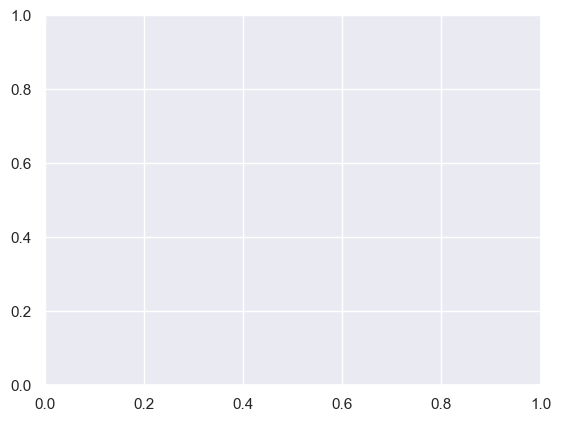

In [37]:
X.plot.scatter(x = 'median_lat', y = 'median_lon', s=50, cmap='viridis')
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5)

In [19]:
import geopandas as gpd
from libpysal.weights import Rook

# Carregue o shapefile
gdf = gpd.read_file(r"C:\Users\Cliente\OneDrive\UNIRIO\TCC\GPK\Seccao_Area_de_Interesse.shp")

# Crie a matriz de adjacências usando o método Queen de libpysal
w = Rook.from_dataframe(gdf)

# A matriz de adjacências completa é obtida com w.full()
full_matrix, ids = w.full()

# A matriz de adjacências completa é armazenada em full_matrix
# Os IDs dos polígonos são armazenados em ids

C:\Users\Cliente\AppData\Local\Temp\ipykernel_19032\2648537907.py:8: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  w = Rook.from_dataframe(gdf)


In [20]:
import pandas as pd

# Convert the matrix to a DataFrame
df_matrix = pd.DataFrame(full_matrix)
 

# Export the DataFrame to a CSV file
df_matrix.to_csv(r"C:\Users\Cliente\OneDrive\UNIRIO\TCC\matrix_seccao_rook", index=False)


In [23]:
# Replace ids with corresponding line in column OBJECTID
ids = [gdf['DTMNFRSEC2'].iloc[i] for i in ids]
# gdf['OBJECTID'].iloc[0]

In [24]:
with open(r"C:\Users\Cliente\OneDrive\UNIRIO\TCC\ids_matrix_seccao_rook.csv", "w") as f:
    f.write("")

<Axes: >

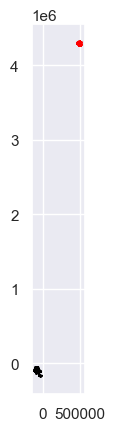

In [48]:
import numpy as np

# Get the number of polygons in gdf
num_polygons = len(gdf)

# Initialize an empty matrix
flow_matrix = np.zeros((num_polygons, num_polygons))

# Iterate over the edges in G2
for source, target in G2.edges:
    # Check if the source and target nodes are polygons in gdf
    if source in gdf['DTMNFRSEC2'].values and target in gdf['DTMNFRSEC2'].values:
        # Get the indices of the source and target polygons in gdf
        source_idx = gdf.index[gdf['DTMNFRSEC2'] == source].tolist()[0]
        target_idx = gdf.index[gdf['DTMNFRSEC2'] == target].tolist()[0]
        
        # Increment the corresponding cell in the matrix
        flow_matrix[source_idx, target_idx] += 1

# Return the flow matrix
flow_matrix
